In [23]:

from pathlib import Path
from collections import deque

import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_smooth_hist(image, smoothing):
    
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    normalized = histogram / np.max(histogram) * 255

    flattened = np.ndarray.flatten(normalized)
    smoothed = np.convolve(flattened, np.ones(smoothing)/smoothing, mode='same')

    return smoothed

def bfs_coloring(image):

    rows, cols = image.shape
    visited = np.zeros_like(image).astype("bool")
    colors = np.zeros_like(image).astype("uint8")

    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def is_within_bounds(x, y):
        return 0 <= x < rows and 0 <= y < cols

    def bfs(x, y, color):
        queue = deque([(x, y)])
        visited[x][y] = True
        colors[x][y] = color

        while queue:
            current_x, current_y = queue.popleft()

            for dx, dy in directions:
                new_x, new_y = current_x + dx, current_y + dy
                if is_within_bounds(new_x, new_y) and not visited[new_x][new_y] and image[new_x][new_y] == 1:
                    queue.append((new_x, new_y))
                    visited[new_x][new_y] = True
                    colors[new_x][new_y] = color

    color_count = 0
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j] and image[i][j] == 1:
                color_count += 1
                bfs(i, j, color_count)

    return colors

def calcuate_centroids(image):

    points = []

    for i in range(1, np.max(image) + 1):
        copy = np.zeros_like(image)
        copy[image == i] = 1

        if np.sum(copy) < 90:
            continue

        moments = cv2.moments(copy, True)
        points.append([int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"])])

    return points

image = cv2.imread(Path("./cv10_mince.jpg").as_posix())
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blackhat = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, np.ones((3, 3), np.uint8), iterations=20)
blackhat_hist = calculate_smooth_hist(blackhat, 3)

blackhat = cv2.medianBlur(blackhat, ksize=7)
threshold = 7.5

segmentation = np.zeros_like(blackhat)
segmentation[blackhat < threshold] = 0
segmentation[blackhat >= threshold] = 1

rows = 3
cols = 4

morph = segmentation.copy()
morph = cv2.erode(morph, np.ones((3, 3), np.uint8))
morph = cv2.dilate(morph, np.ones((3, 3), np.uint8), iterations=5)

dist_transform = cv2.distanceTransform(morph, cv2.DIST_L2, 3)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
morph = np.uint8(morph)
unknown = cv2.subtract(morph * 255, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

outlined = image.copy()
markers_water = cv2.watershed(image, markers)
outlined[markers_water == -1] = [0, 255, 0]

points = calcuate_centroids(markers)[1:]
print(points)



[[238, 89], [121, 127], [207, 206], [97, 243], [313, 262]]


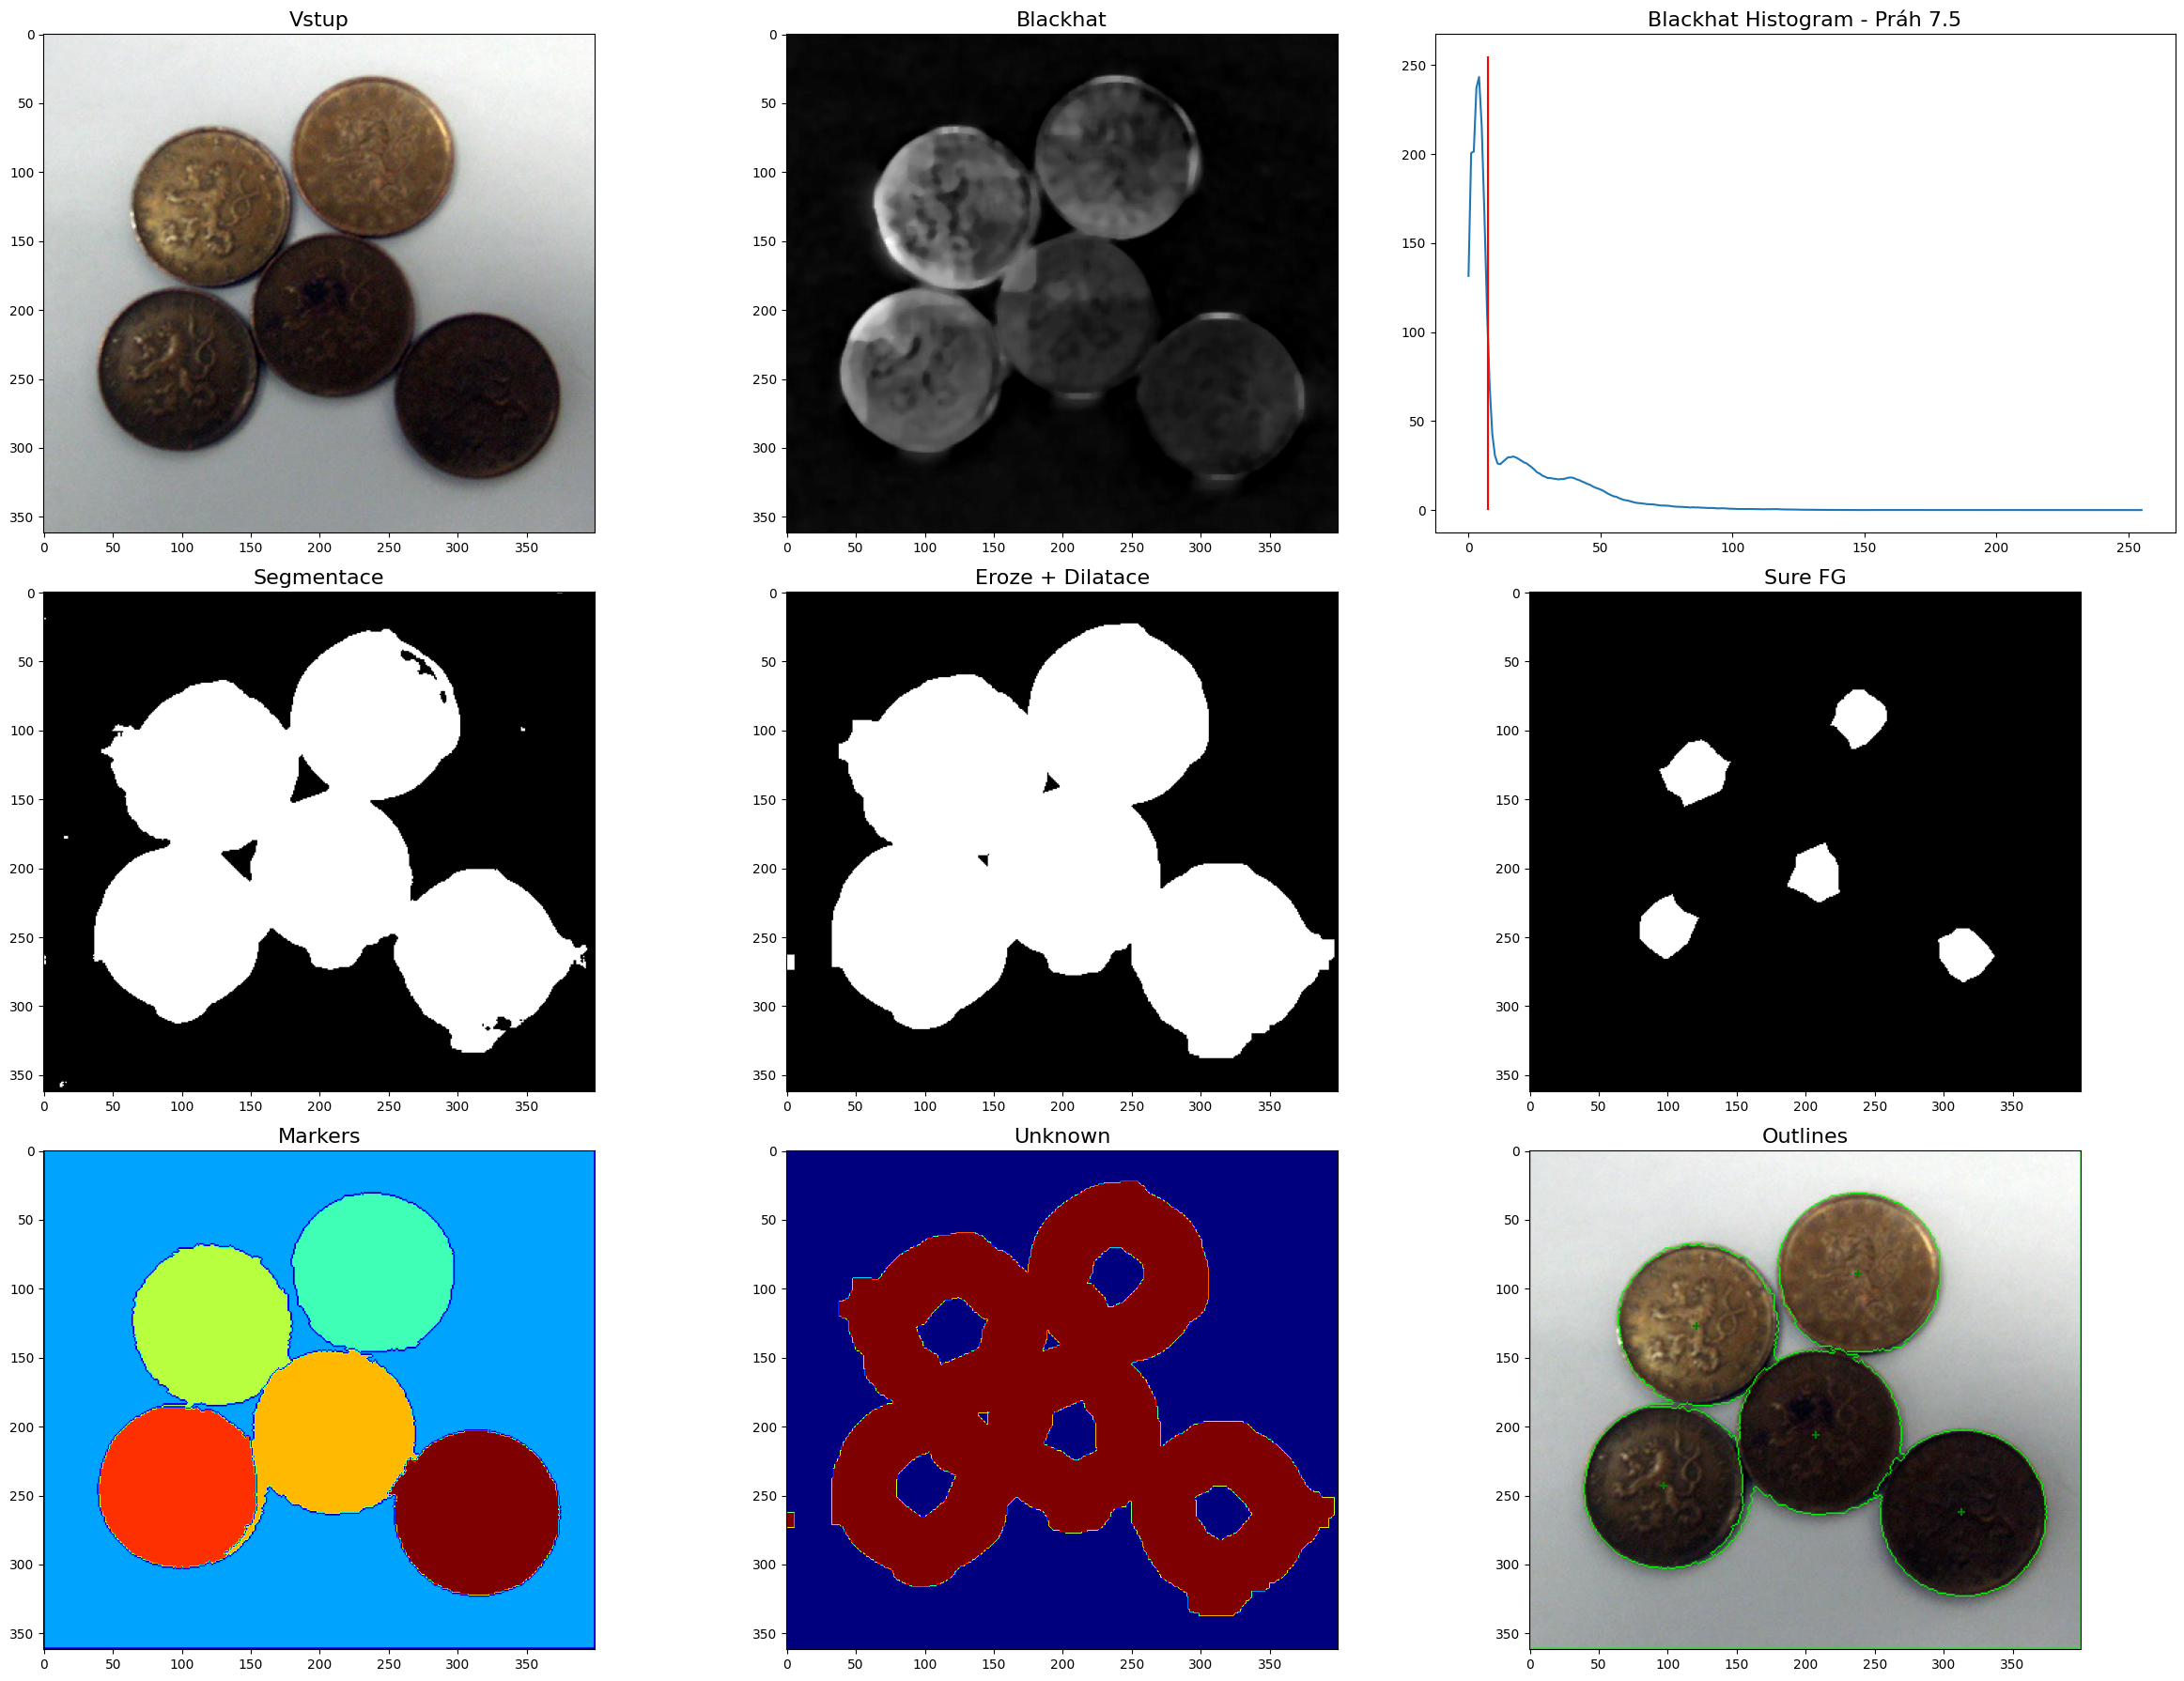

In [27]:
# Set the figure size larger and adjust subplot parameters
plt.figure(figsize=(24, 18))  # Increase the figure size to make each subplot larger

# Number of rows and columns
rows = 3
cols = 3

# Display the images and histograms
plt.subplot(rows, cols, 1)
plt.imshow(image, cmap="gray")
plt.title("Vstup", fontsize=16)

plt.subplot(rows, cols, 2)
plt.imshow(blackhat, cmap="gray")
plt.title("Blackhat", fontsize=16)

plt.subplot(rows, cols, 3)
plt.plot(blackhat_hist)
plt.vlines([threshold], 0, 255, "red")
plt.title(f"Blackhat Histogram - Práh {threshold}", fontsize=16)

plt.subplot(rows, cols, 4)
plt.imshow(segmentation, cmap="gray")
plt.title("Segmentace", fontsize=16)

plt.subplot(rows, cols, 5)
plt.imshow(morph, cmap="gray")
plt.title("Eroze + Dilatace", fontsize=16)

plt.subplot(rows, cols, 6)
plt.imshow(sure_fg, cmap="gray")
plt.title("Sure FG", fontsize=16)

plt.subplot(rows, cols, 7)
plt.imshow(markers, cmap="jet")
plt.title("Markers", fontsize=16)

plt.subplot(rows, cols, 8)
plt.imshow(unknown, cmap="jet")
plt.title("Unknown", fontsize=16)

plt.subplot(rows, cols, 9)
plt.imshow(outlined)
plt.scatter(*zip(*points), marker="+", color="green")
plt.title("Outlines", fontsize=16)

plt.tight_layout()  # Adjust the layout to prevent overlap and make it clearer
plt.show()


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/morph.simd.hpp:756: error: (-213:The function/feature is not implemented) Unsupported data type (=4) in function 'getMorphologyRowFilter'
